In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
from tqdm import tqdm
import warnings
from keras.models import *
from keras.layers import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras import Model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [2]:
warnings.filterwarnings('ignore')
plt.rcParams["figure.dpi"] = 120
image_height = 256
image_width = 256
image_depth = 1
epochs=100
batch_size = 1
epoch_index = [i for i in range(1, epochs+1)]

#### Load data

In [3]:
images = np.load(os.path.join("Brain_MRI_data1", "images.npy"), allow_pickle=True)
masks = np.load(os.path.join("Brain_MRI_data1", "masks.npy"), allow_pickle=True)

#### Change all image to grey

In [4]:
image_index = 0
for image in tqdm(images):
    plt.imsave(os.path.join("Brain_MRI_Segment_image", "image_{}.jpg".format(image_index)), image, cmap='gray')
    image_index += 1

mask_index = 0
for mask in tqdm(masks):
    plt.imsave(os.path.join("Brain_MRI_Segment_mask", "mask_{}.jpg".format(mask_index)), mask, cmap='gray')
    mask_index += 1

100%|██████████| 3064/3064 [00:24<00:00, 127.58it/s]


In [3]:
image_dir_name = "Brain_MRI_Segment_image"
mask_dir_name = "Brain_MRI_Segment_mask"
image_list = list()
mask_list = list()

images_dir = sorted(os.listdir(image_dir_name))
for image in tqdm(images_dir):
    current_image = cv2.imread(os.path.join(image_dir_name, image), cv2.IMREAD_GRAYSCALE)
    current_image = cv2.resize(current_image, (image_height, image_width))
    current_image_180 = cv2.rotate(current_image, cv2.ROTATE_180)
    current_image_r90 = cv2.rotate(current_image, cv2.ROTATE_90_CLOCKWISE)
    current_image_l90 = cv2.rotate(current_image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    image_list.append(current_image)
    image_list.append(current_image_180)
    image_list.append(current_image_r90)
    image_list.append(current_image_l90)



masks_dir = sorted(os.listdir(mask_dir_name))
for mask in tqdm(masks_dir):
    current_mask = cv2.imread(os.path.join(mask_dir_name, mask), cv2.IMREAD_GRAYSCALE)
    current_mask = cv2.resize(current_mask, (image_height, image_width))
    current_mask_180 = cv2.rotate(current_mask, cv2.ROTATE_180)
    current_mask_r90 = cv2.rotate(current_mask, cv2.ROTATE_90_CLOCKWISE)
    current_mask_l90 = cv2.rotate(current_mask, cv2.ROTATE_90_COUNTERCLOCKWISE)
    mask_list.append(current_mask)
    mask_list.append(current_mask_180)
    mask_list.append(current_mask_r90)
    mask_list.append(current_mask_l90)


features = np.array(image_list)/255.0
masks = np.array(mask_list)/255.0
features = features.reshape((features.shape[0], features.shape[1], features.shape[2], 1))
masks = masks.reshape((masks.shape[0], masks.shape[1], masks.shape[2], 1))

100%|██████████| 3064/3064 [00:02<00:00, 1190.22it/s]


In [4]:
print("image dimension: {}, label dimension: {}".format(features.shape, masks.shape))

image dimension: (12256, 256, 256, 1), label dimension: (12256, 256, 256, 1)


#### Train, Test, Validation Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(features, masks, test_size=0.25, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, shuffle=True)
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')
y_val = y_val.astype("float32")

In [6]:
# Save model function
def save_model(model_name):
    checkpoint = tf.keras.callbacks.ModelCheckpoint(os.path.join("trained_model_weights", model_name),
                                                    monitor='val_iou',
                                                    verbose=1,
                                                    save_best_only=True,
                                                    mode='max')
    return [checkpoint]

#### Define U-Net Model and Loss Function

In [7]:
smooth =100
def iou(y_true, y_pred):
    intersection = keras.sum(y_true * y_pred)
    sum_ = keras.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2 * intersection + smooth) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)



# def unet(input_size=(256,256,1)):
#     inputs = Input(input_size)
#
#     conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
#     conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
#
#     conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
#     conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
#
#     conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
#     conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
#
#     conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
#     conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
#     pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
#
#     conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
#     conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
#
#     up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
#     conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
#     conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
#
#     up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
#     conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
#     conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
#
#     up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
#     conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
#     conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
#
#     up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
#     conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
#     conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
#
#     conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
#
#     return Model(inputs=[inputs], outputs=[conv10])

def unet(pretrained_weights = None,input_size = (256,256,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    bn_1 = BatchNormalization(axis=3)(conv1)
    act_1 = Activation('relu')(bn_1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(act_1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    bn_2 = BatchNormalization(axis=3)(conv2)
    act_2 = Activation('relu')(bn_2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(act_2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv3)
    bn_3 = BatchNormalization(axis=3)(conv3)
    act_3 = Activation('relu')(bn_3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(act_3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv4)
    bn_4 = BatchNormalization(axis=3)(conv4)
    act_4 = Activation('relu')(bn_4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(act_4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    bn_5 = BatchNormalization(axis=3)(conv5)
    act_5 = Activation('relu')(bn_5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(act_5))
    merge6 = concatenate([conv4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv6)
    bn_6 = BatchNormalization(axis=3)(conv6)
    act_6 = Activation('relu')(bn_6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(act_6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv7)
    bn_7 = BatchNormalization(axis=3)(conv7)
    act_7 = Activation('relu')(bn_7)


    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(act_7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv8)
    bn_8 = BatchNormalization(axis=3)(conv8)
    act_8 = Activation('relu')(bn_8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(act_8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv9)
    bn_9 = BatchNormalization(axis=3)(conv9)
    act_9 = Activation('relu')(bn_9)

    conv10 = Conv2D(1, 1, activation = 'sigmoid')(act_9)

    model = Model(inputs=[inputs] , outputs = [conv10])
    return model

In [8]:
unet_path = "unet.hdf5"
model_Unet = unet(input_size=(image_height,image_width,1))
model_Unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-3/32, amsgrad=False),
              loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])
model_Unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d_1[0][0]                   
______________________________________________________________________________________________

In [9]:
unet_history = model_Unet.fit(x=X_train,y=y_train, epochs=epochs, verbose=1, batch_size=8, validation_data=(X_val, y_val), callbacks=save_model(unet_path))

Epoch 1/100
862/862 [==============================] - 162s 176ms/step - loss: 0.8917 - binary_accuracy: 0.9593 - iou: 0.0585 - dice_coef: 0.1083 - val_loss: 0.9682 - val_binary_accuracy: 0.9748 - val_iou: 0.0197 - val_dice_coef: 0.0323

Epoch 00001: val_iou improved from -inf to 0.01973, saving model to trained_model_weights\unet.hdf5
Epoch 2/100
862/862 [==============================] - 144s 167ms/step - loss: 0.6530 - binary_accuracy: 0.9673 - iou: 0.2180 - dice_coef: 0.3470 - val_loss: 0.5954 - val_binary_accuracy: 0.9831 - val_iou: 0.2644 - val_dice_coef: 0.4036

Epoch 00002: val_iou improved from 0.01973 to 0.26440, saving model to trained_model_weights\unet.hdf5
Epoch 3/100
862/862 [==============================] - 140s 162ms/step - loss: 0.5089 - binary_accuracy: 0.9799 - iou: 0.3343 - dice_coef: 0.4912 - val_loss: 0.7581 - val_binary_accuracy: 0.9817 - val_iou: 0.1493 - val_dice_coef: 0.2421

Epoch 00003: val_iou did not improve from 0.26440
Epoch 4/100
862/862 [============

Text(0.5, 1.0, 'Unet for segmentation')

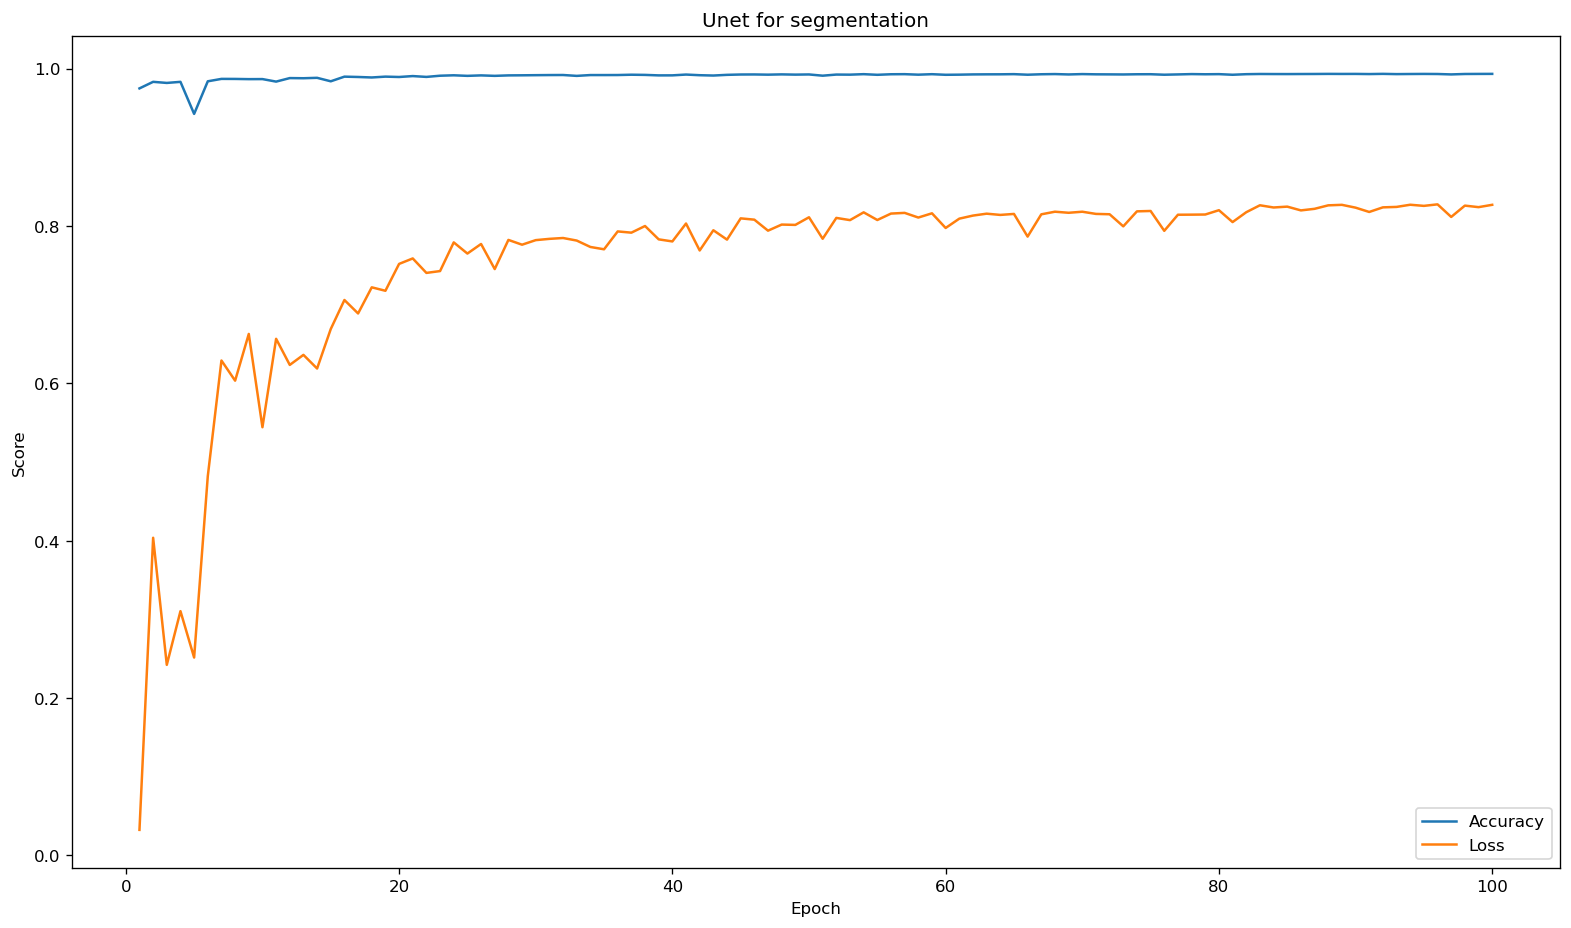

In [10]:
model_Unet_result = pd.DataFrame({"Accuracy": unet_history.history["val_binary_accuracy"],
                                  "Loss": unet_history.history["val_dice_coef"]}, index=epoch_index)
model_Unet_result.to_csv("Unet_result.csv")
ax_unet = model_Unet_result.plot.line(figsize=(16, 9))
ax_unet.set_xlabel("Epoch")
ax_unet.set_ylabel("Score")
ax_unet.set_title("Unet for segmentation")

In [11]:
model_Unet.load_weights(os.path.join("trained_model_weights", unet_path))
model_Unet.evaluate(x=X_test, y=y_test)

ResourceExhaustedError:  OOM when allocating tensor with shape[32,128,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/conv2d_19/Conv2D-0-TransposeNHWCToNCHW-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_test_function_7819]

Function call stack:
test_function


In [ ]:
model_Unet.predict(x=X_test)

In [19]:
test = X_test[0]
test = np.reshape(test, (1, 256, 256, 1))
truth = y_test[0]
truth = np.reshape(truth, (1, 256, 256, 1))

In [20]:
predicted = model_Unet.predict(x=test)

In [21]:
model_Unet.evaluate(x=predicted, y=truth)

1/1 [==============================] - 0s 168ms/step - loss: 0.3599 - binary_accuracy: 0.9905 - iou: 0.4923 - dice_coef: 0.6401


[0.35986918210983276,
 0.990509033203125,
 0.4923485219478607,
 0.6401308178901672]

In [22]:
predicted = predicted.reshape(256, 256, 1)

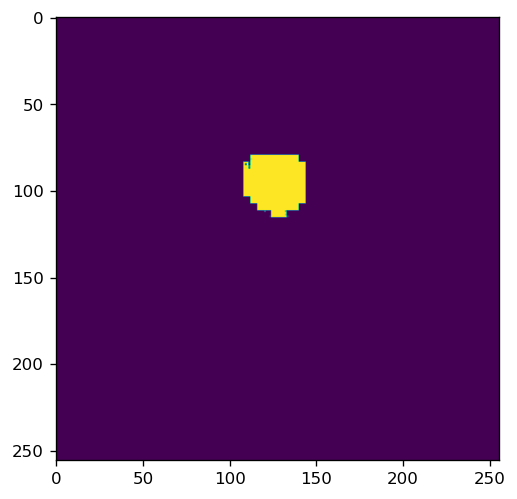

In [23]:
plt.imshow(predicted)

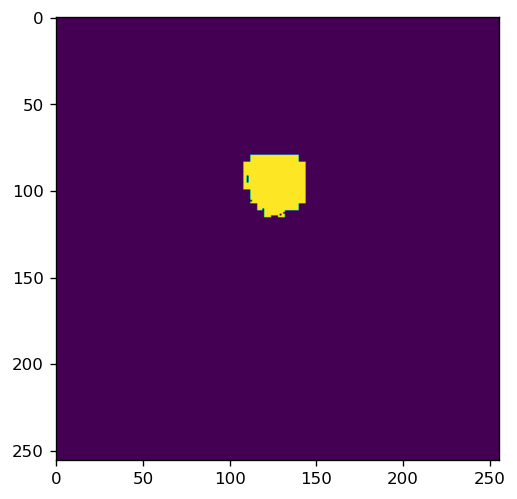

In [26]:
plt.imshow(y_test[0])

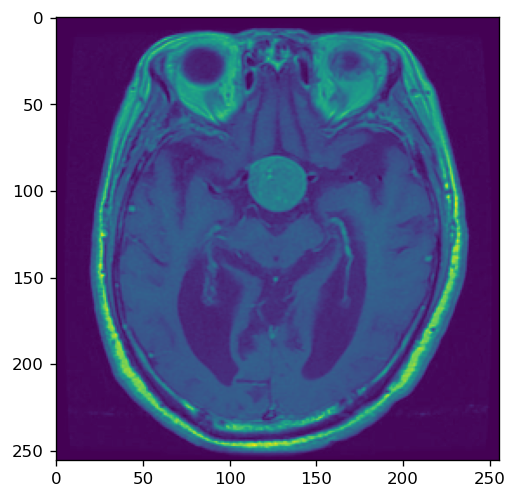

In [27]:
plt.imshow(X_test[0])